For the first initial model, I wanted to run Logistic Regression since it seems to be one of the easier models to understand. Since my data was also a binary Yes/No I figured that this would make modeling much easier. During previous EDA I created a DataFrame containing the Arrest Flag column to use as my target Y and the remaining columns would be my predictors X.

In [21]:
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
df1 = pd.read_csv('EDA_df.csv')
df1.head()

,Unnamed: 0,Subject Age Group,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Arrest Flag,Frisk Flag
0,0,Unknown,Arrest,None,7500,1980s,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,N,N
1,1,Unknown,Field Contact,None,5670,1960s,M,White,Unknown,Unknown,2015-03-19T00:00:00,07:59:00,N,N
2,3,Unknown,Field Contact,None,7539,1960s,M,White,Unknown,Unknown,2015-04-01T00:00:00,04:55:00,N,N
3,4,Unknown,Field Contact,None,6973,1970s,M,White,Black or African American,Male,2015-04-03T00:00:00,00:41:00,N,N
4,5,Unknown,Field Contact,None,7402,1970s,M,White,Black or African American,Male,2015-04-05T00:00:00,23:46:00,N,N


In [4]:
target = df1['Arrest Flag']
predictors = df1.drop(columns = ['Arrest Flag'], axis = 1)

Checking the distribution of values for the target column. To make calculations easier I change the N/Y to 0/1 for easier calculations.

In [5]:
df1['Arrest Flag'].value_counts()

N    42114
Y     2735
Name: Arrest Flag, dtype: int64

In [6]:
target.replace({"N": 0, "Y": 1}, inplace=True)

In [7]:
predictors['Frisk Flag'].replace({"N": 0, "Y": 1}, inplace=True)

To set up for modeling I create dummy variables and and then do a train_test_split. I also scale the data so it can run through the LogisticRegression model smoothly.

In [9]:
dummy_predictors = pd.get_dummies(predictors, drop_first=False)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dummy_predictors, target, random_state=11)

In [11]:
stdscale = StandardScaler()
X_train = stdscale.fit_transform(X_train)
X_test = stdscale.transform(X_test)

In [12]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False)

In [13]:
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

Starting assessment of how well the model ran, somehow it shows that it has 100% predicting accuracy on the training set... however that seems too good to be true. Also with a previous run, I had a 99% for training and test while using the same random_state. Regardless, having it show that I had a nearly 85% predicting power for the test set was something nice to see.

In [14]:
y_hat_train.astype('float64')
y_train.astype('float64')

residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    33636
Name: Arrest Flag, dtype: int64
0    1.0
Name: Arrest Flag, dtype: float64


In [15]:
y_hat_test.astype('float64')
y_test.astype('float64')

residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    9528
1    1685
Name: Arrest Flag, dtype: int64
0    0.849728
1    0.150272
Name: Arrest Flag, dtype: float64


Lastly I will be creating a confusion matrix and plotting a quick visualization for it, as well as doing calculations for precision, recall, accuracy, and F1.

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [17]:
def conf_matrix(y_true, y_pred):
    cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}   
    for ind, label in enumerate(y_true):
        pred = y_pred[ind]
        if label == 1: 
            if label == pred:
                cm['TP'] += 1
            else:
                cm['FN'] += 1
        else:
            if label == pred:
                cm['TN'] += 1
            else:
                cm['FP'] += 1
    return cm

conf_matrix(y_test, y_hat_test)

{'TP': 540, 'TN': 8988, 'FP': 1571, 'FN': 114}

In [18]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
cnf_matrix

array([[8988, 1571],
       [ 114,  540]], dtype=int64)

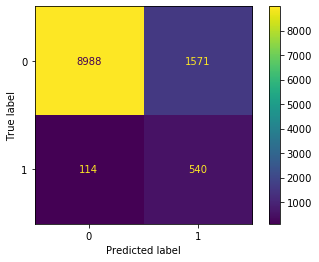

In [22]:
plot_confusion_matrix(logreg, X_test, y_test)
plt.show()

In [36]:
def model_eval(YTrain, YTest, YHat_Train, YHat_Test):
    PrecisionTrain = precision_score(YTrain, YHat_Train)
    PrecisionTest = precision_score(YTest, YHat_Test)
    RecallTrain = recall_score(YTrain, YHat_Train)
    RecallTest = recall_score(YTest, YHat_Test)
    AccuracyTrain = accuracy_score(YTrain, YHat_Train)
    AccuracyTest = accuracy_score(YTest, YHat_Test)
    F1Train = f1_score(YTrain, YHat_Train)
    F1Test = f1_score(YTest, YHat_Test)
    print('Precision Score:\nTrain: {}  Test: {}\nRecall Score:\nTrain: {}  Test {}\nAccuracy Score:\nTrain: {}  Test: {}\nF1 Score:\nTrain: {}  Test: {}'.format(
                                                    PrecisionTrain, PrecisionTest, RecallTrain, RecallTest, 
                                                    AccuracyTrain, AccuracyTest, F1Train, F1Test))

In [38]:
model_eval(y_train, y_test, y_hat_train, y_hat_test)

Precision Score:
Train: 1.0  Test: 0.25580293699668405
Recall Score:
Train: 1.0  Test 0.8256880733944955
Accuracy Score:
Train: 1.0  Test: 0.8497279942923393
F1 Score:
Train: 1.0  Test: 0.3905967450271248


the precision and F1 score leave much to be desired, but recall and accuracy seem to be more of what I would expect. It will be interesting to see how these change as I continue to test different modeling approaches.